# Working with Chemical Data
As we discussed in our lecture, using computers to manipulate data about molecules goes [back to the infancy of modern computing.](https://pubs.acs.org/doi/abs/10.1021/cen-v030n034.p3523)
This notebook is designed to show you that tools to use computers have, indeed, evolved rapidly alongside computing.

In particular, we focus on RDKit - a library for chemoinformatics that works well with Python.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from rdkit import Chem  # Common functionality from RDKit is available in the Chem module
from rdkit.Chem import AllChem  # Most of the other functions are in AllChem and other modules
import pandas as pd
import numpy as np
import gzip
import json

## Parsing Chemical Data
The data for our lesson is stored as line-delimited JSON, where each individual record is a dictionary that contains some information about a molecule and a name that captures the molecular structure

### Part 1: Getting the Data off Disk
We first solve a problem that has nothing to do with chemistry: reading a table into Python.

In [2]:
data_path = '../datasets/qm9.json.gz'
with gzip.open(data_path, 'rt') as fp:
    record = fp.readline().strip()
print(record)

{"A":157.7118,"B":157.70997,"C":157.70699,"R2":35.3641,"alpha":13.21,"atomic_charges":[-0.535689,0.133921,0.133922,0.133923,0.133923],"bandgap":0.5048,"cv":6.469,"filename":"dsgdb9nsd_000001.xyz","g":-40.498597,"g4mp2_0k":-40.427662,"g4mp2_atom":-0.625083,"g4mp2_energy":-40.424791,"g4mp2_enthalpy":-40.423846,"g4mp2_free":-40.447329,"g4mp2_hf298":-17.640634,"g4mp2_zpe":0.044097,"h":-40.475117,"homo":-0.3877,"inchi_0":"InChI=1S\/CH4\/h1H4","inchi_1":"InChI=1S\/CH4\/h1H4","index":1,"lumo":0.1171,"mu":0.0,"n_atom":5,"n_electrons":10,"n_heavy_atoms":1,"smiles_0":"C","smiles_1":"C","u":-40.476062,"u0":-40.47893,"u0_atom":-0.631066,"xyz":"5\nProperties=species:S:1:pos:R:3 unique_id=40ace0c47819e1c39d44d17bc0e00b4c pbc=\"F F F\"\nC      -0.01269814       1.08580416       0.00800100 \nH       0.00215042      -0.00603132       0.00197612 \nH       1.01173084       1.46375116       0.00027657 \nH      -0.54081507       1.44752661      -0.87664372 \nH      -0.52381363       1.43793264       0.9063

We need to do two things to make this data usable. First, take that record and parse it into a Python dictionary.

In [3]:
json.loads(record)

{'A': 157.7118,
 'B': 157.70997,
 'C': 157.70699,
 'R2': 35.3641,
 'alpha': 13.21,
 'atomic_charges': [-0.535689, 0.133921, 0.133922, 0.133923, 0.133923],
 'bandgap': 0.5048,
 'cv': 6.469,
 'filename': 'dsgdb9nsd_000001.xyz',
 'g': -40.498597,
 'g4mp2_0k': -40.427662,
 'g4mp2_atom': -0.625083,
 'g4mp2_energy': -40.424791,
 'g4mp2_enthalpy': -40.423846,
 'g4mp2_free': -40.447329,
 'g4mp2_hf298': -17.640634,
 'g4mp2_zpe': 0.044097,
 'h': -40.475117,
 'homo': -0.3877,
 'inchi_0': 'InChI=1S/CH4/h1H4',
 'inchi_1': 'InChI=1S/CH4/h1H4',
 'index': 1,
 'lumo': 0.1171,
 'mu': 0.0,
 'n_atom': 5,
 'n_electrons': 10,
 'n_heavy_atoms': 1,
 'smiles_0': 'C',
 'smiles_1': 'C',
 'u': -40.476062,
 'u0': -40.47893,
 'u0_atom': -0.631066,
 'xyz': '5\nProperties=species:S:1:pos:R:3 unique_id=40ace0c47819e1c39d44d17bc0e00b4c pbc="F F F"\nC      -0.01269814       1.08580416       0.00800100 \nH       0.00215042      -0.00603132       0.00197612 \nH       1.01173084       1.46375116       0.00027657 \nH      -

And, second, making it easy to work with a lot of these dictionaries at once.

For this purpose, we use [Pandas](https://pandas.pydata.org/docs/user_guide/index.html).

In [4]:
data = pd.read_json(data_path, lines=True).head(1000)  # Only get the first 1000 for simplicity

In [5]:
data[['smiles_0', 'inchi_0', 'u']].head(5)

,smiles_0,inchi_0,u
0,C,InChI=1S/CH4/h1H4,-40.476062
1,N,InChI=1S/H3N/h1H3,-56.523026
2,O,InChI=1S/H2O/h1H2,-76.401867
3,C#C,InChI=1S/C2H2/c1-2/h1-2H,-77.305527
4,C#N,InChI=1S/CHN/c1-2/h1H,-93.409370


The above commands read the file from disk ([`read_json`](https://pandas.pydata.org/docs/user_guide/io.html#json)) and then displays a fraction of the table. I display the table to show that this object represents, in a sense, a big table or digital spreadsheet.

We'll touch on a few concepts of Pandas throughout these notebooks but I would highly recommend [10 minutes to Pandas](https://pandas.pydata.org/docs/user_guide/10min.html) if you have not used Pandas before.

### Part 2: Parsing Chemical Structures
The molecular structure of each record are recorded as ["SMILES"](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) and ["InChI"](https://en.wikipedia.org/wiki/International_Chemical_Identifier) strings. 

*Aside*: Both of SMILES and InChI are from a long tradition of methods in chemistry for writing out molecules as a string of printable characters that can be read by computers. 
The short of it is that SMILES strings are easily human-readable and InChI guarantee a unique string. 
For example, methanol can be both `CO` or `OC` in SMILES but only `InChI=1S/CH4O/c1-2/h2H,1H3` in InChI. 

RDKit provides functionality for parsing both. Here, we are going to use the SMILES string to create a molecule object.

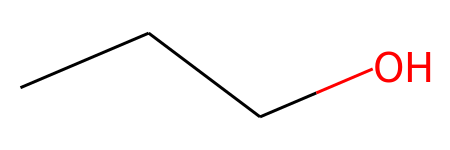

In [6]:
mol = Chem.MolFromSmiles('CCCO')
mol

If JupyterLab is a recent version, you should see a visual of [1-propanol](https://en.wikipedia.org/wiki/1-Propanol).
We will see more about what you can do with `mol` later, but the fact that your computer knew what `CCCO` means is because RDKit can read SMILES.

Now, let's parse all of the molecules using Panda's map function. 

In [7]:
data['mol'] = data['smiles_0'].map(Chem.MolFromSmiles)

## Manipulating Molecules
Once molecules are parsed, you can make many kinds of queries about them. 

For now, we use the 1-Propanol molecule from earlier as an example

### Basic Functionality
RDKit treats the molecule as a Python object and, accordingly, you can interact with it using some functions

In [8]:
for i, a in enumerate(mol.GetAtoms()):
    print(f'Atom {i} is an {a.GetSymbol()}')

Atom 0 is an C
Atom 1 is an C
Atom 2 is an C
Atom 3 is an O


Note that it initially treats the molecule with _implicit_ hydrogrens, which you can add by calling a method from the `Chem` module

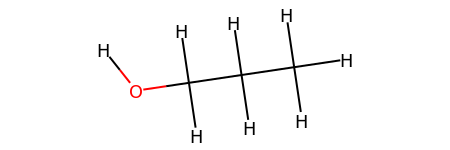

In [9]:
mol = Chem.AddHs(mol)
mol

In [10]:
for i, a in enumerate(mol.GetAtoms()):
    print(f'Atom {i} is an {a.GetSymbol()}')

Atom 0 is an C
Atom 1 is an C
Atom 2 is an C
Atom 3 is an O
Atom 4 is an H
Atom 5 is an H
Atom 6 is an H
Atom 7 is an H
Atom 8 is an H
Atom 9 is an H
Atom 10 is an H
Atom 11 is an H


You can also do more sophisticated things like, find all rings

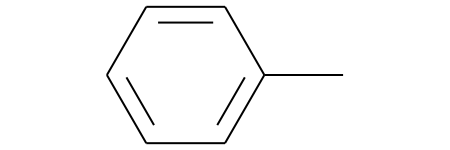

In [11]:
toluene = Chem.MolFromSmiles('Cc1ccccc1')
toluene

In [12]:
r = toluene.GetRingInfo()
print(f'Toluene has {r.NumRings()} ring')

Toluene has 1 ring


You can imagine that RDKit has many capabilities for describing molecules

### Descriptors
Hence, RDKit is a source of [many different "descriptors" for molecules](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors). We'll demonstrate a few for concepts.

Some generate `float` or `int` values, which can be directly used by Python

In [13]:
print(f'Toluene has {AllChem.CalcNumRotatableBonds(toluene)} rotatable bonds')

Toluene has 0 rotatable bonds


Others are in C++ objects which, while similar to Python objects, should be converted to a Python standard type.

*Aside*: This has to do with parts of RDKit being written in C++. 

In [14]:
r = AllChem.BCUT2D(mol)
r

### Fingerprints
Another class of descriptor are "fingerprints," which seek to encode the entire molecule as a fixed length vector of bits. RDKit [implements a few of these](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-fingerprints)

In [15]:
bv = AllChem.GetMorganFingerprintAsBitVect(mol, 4, 16)
bv

In [16]:
np.asarray(bv)

array([0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1])

As we will see later, both fingerprints and descriptors provide complementary routes for training machine learning models.